In [2]:
import pandas as pd
import scirpy as ir
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import scanpy as sc
%matplotlib inline
from matplotlib import pyplot as plt
import Levenshtein
import matplotlib as mpl
import seaborn as sns
import autoreload
import scipy
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20) 
pd.set_option('display.width', 100)

# load the data

In [2]:
# output of snakemake currently, goal is to integrate this whole analysis into snakemake
airr = pd.read_table('../data/snkmk_outs/combined_igblast.airr.tsv')

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (93,94) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# filter and munge

In [6]:
# get rid of merging artefacts
print("{} total assemblies out of snakemake".format(airr.shape[0]))
airr = airr.dropna(subset=['locus'])
print(airr.shape[0], "removed presumed merging artefacts")
airr = airr[airr.productive == "T"]
print(airr.shape[0], "removed unproductive chains")
airr = airr.dropna(subset=['locus'])

print("{} assemblies from TS".format(airr.shape[0]))

#10X
airr.loc[:,"cell_id"] = airr.sequence_id.replace('_contig_[0-9]', '', regex=True)
airr.cell_id.replace("\-","_", regex=True, inplace=True)
# 10X
airr.cell_id.replace("_5prime..CR", '_5prime', regex = True, inplace = True)
airr.cell_id.replace('_[0-9]_[T][S]', '_TS',regex = True, inplace = True)
airr.cell_id.replace('10X_[0-9]_[0-9]', '10X',regex = True, inplace = True)
airr.loc[:, 'cell_id'] = airr.cell_id.str.rsplit(" ", expand=True)[0]

airr.head().cell_id.values[-20:]
# Munge the data a little
airr.loc[:, 'cell_id'] = airr.cell_id.str.split('|', expand=True)[0]
airr = airr.dropna(subset=['junction'])

# scirpy needs umi_count column 
airr['umi_count'] = airr['umis']
airr['umi_count'].fillna(5, inplace=True)
airr['is_cell'] = True
airr['high_confidence'] = True
airr['multi_chain'] = False
# Want to assign c_calls in the snakemake that's a todo
airr['c_call'] = 'None'
# umi_count filled with dummy 5, SS2 data wouldn't have this info
airr['umi_count'].fillna(5, inplace=True)
# rename column
airr = airr.rename({'cell_id_x':'cell_id'}, axis=1)
"""airr = airr[['sequence_id', 'sequence', 'rev_comp', 'sequence_alignment', 'germline_alignment', 
             'v_cigar', 'd_cigar', 'j_cigar', 'cell_id', 'productive', 
             'locus', 'v_call', 'd_call', 'j_call', 'c_call', 'junction', 
             'junction_aa', 'umi_count', 'is_cell']]
"""

17735 total assemblies out of snakemake
17735 removed presumed merging artefacts
17735 removed unproductive chains
17735 assemblies from TS


"airr = airr[['sequence_id', 'sequence', 'rev_comp', 'sequence_alignment', 'germline_alignment', \n             'v_cigar', 'd_cigar', 'j_cigar', 'cell_id', 'productive', \n             'locus', 'v_call', 'd_call', 'j_call', 'c_call', 'junction', \n             'junction_aa', 'umi_count', 'is_cell']]\n"

In [7]:
def calculate_v_mu_freq(df):
    df['distance_to_germline_v'] = df.apply(lambda x: Levenshtein.distance(x.v_sequence_alignment, x.v_germline_alignment), axis=1)


    df['v_mu_freq'] = df['distance_to_germline_v'] / df['v_sequence_alignment'].str.len()
    return df

airr = calculate_v_mu_freq(airr)

# SCIRPY

In [8]:
airr.to_csv('airr_formatted.tsv', sep = '\t')
adata = ir.io.read_airr('airr_formatted.tsv',include_fields=('productive', 'sequence', 'locus', 'v_call', 'd_call', 'j_call', 'c_call', 'junction', 'junction_aa', 'consensus_count', 'duplicate_count', 'v_mu_freq'))

In [3]:
adata = ir.io.read_airr('airr_formatted.tsv',include_fields=('productive', 'sequence', 'locus', 'v_call', 'd_call', 'j_call', 'c_call', 'junction', 'junction_aa', 'consensus_count', 'duplicate_count', 'v_mu_freq'))

In [9]:
ir.tl.chain_qc(adata)

... storing 'receptor_type' as categorical
... storing 'receptor_subtype' as categorical
... storing 'chain_pairing' as categorical


single pair        5595
orphan VJ          2310
orphan VDJ         1737
extra VJ            453
ambiguous           168
extra VDJ            98
two full chains      47
multichain           18
Name: chain_pairing, dtype: int64


<Figure size 432x288 with 0 Axes>

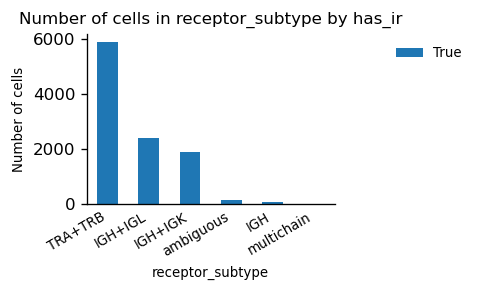

In [10]:
print(adata.obs.chain_pairing.value_counts())
fig = plt.figure()
ax = ir.pl.group_abundance(adata, groupby='receptor_subtype')


In [11]:
# metadata from h5ad
met = pd.read_csv('../data/TSP1_TSP15_metadata.csv')
met[(met.donor == "TSP1") & (met.method == 'smartseq2')].cell_id.str.rsplit(".", n = 5, expand = True)[0]
met['_cell_id'] = met['cell_id']
met['_cell_id'] = met['_cell_id'].str.replace('_[0-2]_[0-2]_5prime', '_5prime', regex = True)
met['_cell_id'] = met['_cell_id'].str.replace('.homo.gencode.v30.ERCC.chrM', '', regex = True)

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (10,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [12]:
merged = pd.merge(adata.obs, met, how = 'inner', left_on='cell_id', right_on='_cell_id')

adata = adata[adata.obs.index.isin(merged.cell_id)]

adata.obs = pd.merge(adata.obs, met, how = 'inner', left_index=True, right_on='cell_id')

adata.obs.index = adata.obs.cell_id

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [143757, 144258, 144244, 143761, 144159]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


adata.obs.index.name = None
adata.obs['10X_run'].fillna("SS2", inplace=True)

adata.write_h5ad('../data/merged_airr_scirpy.h5ad')

In [13]:
adata.obs.columns

Index(['multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call',
       'IR_VDJ_2_c_call', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call',
       'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count',
       'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call',
       'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction',
       'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa',
       'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus',
       'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive',
       'IR_VDJ_2_productive', 'IR_VJ_1_sequence', 'IR_VJ_2_sequence', 'IR_VDJ_1_sequence',
       'IR_VDJ_2_sequence', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call',
       'IR_VDJ_2_v_call', 'IR_VJ_1_v_mu_freq', 'IR_VJ_2_v_mu_freq', 'IR_VDJ_1_v_mu_freq',
    

In [14]:
ir.pp.ir_dist(adata, metric="alignment", sequence='aa')

100%|██████████| 2278/2278 [00:11<00:00, 205.03it/s]


In [15]:
ir.tl.define_clonotypes(adata, key_added='clone_id')

100%|██████████| 4505/4505 [00:05<00:00, 840.18it/s]


In [16]:
adata.obs.to_csv('../data/merged_airr_scirpy.tsv', sep = '\t', index=False)

... storing 'donor' as categorical
... storing 'tissue' as categorical
... storing 'anatomical_position' as categorical
... storing 'method' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'free_annotation' as categorical
... storing 'consensus_prediction' as categorical
... storing 'cDNAplate' as categorical
... storing 'libraryplate' as categorical
... storing 'well' as categorical
... storing 'notes' as categorical
... storing 'clone_id' as categorical


<AxesSubplot:>

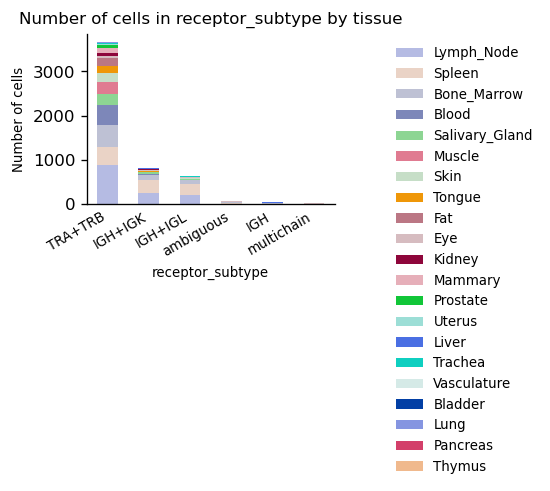

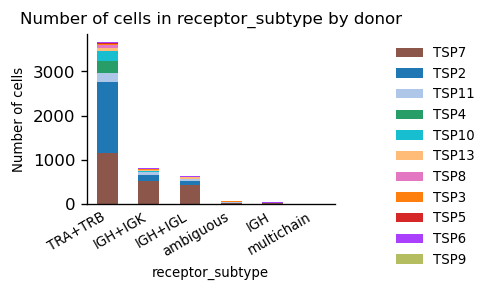

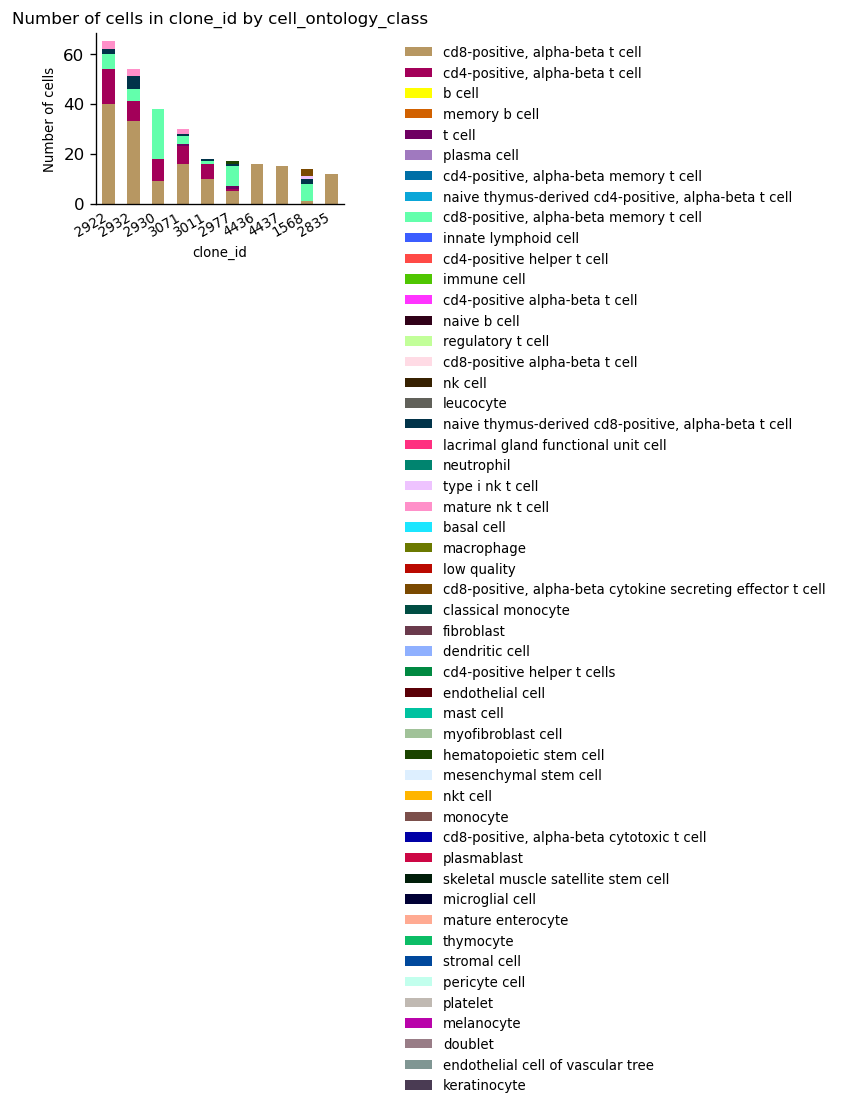

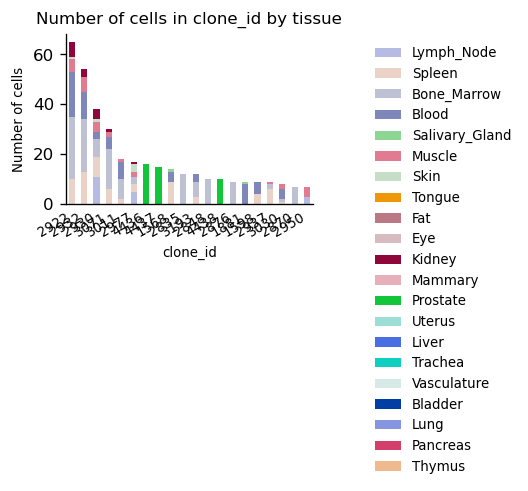

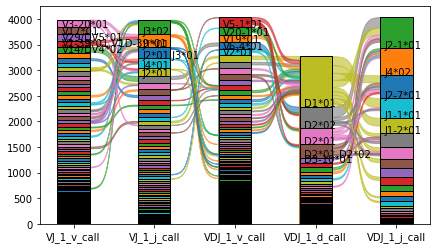

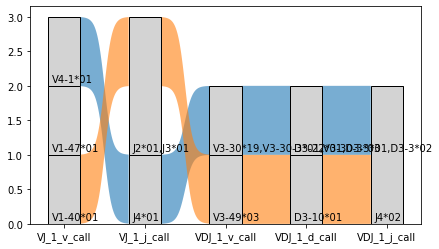

In [17]:
ax = ir.pl.group_abundance(adata, groupby='receptor_subtype', target_col='tissue')

ax = ir.pl.group_abundance(adata, groupby='receptor_subtype', target_col='donor')


ax = ir.pl.group_abundance(adata, groupby='clone_id', target_col='cell_ontology_class', max_cols=10)

ax = ir.pl.group_abundance(adata, groupby='clone_id', target_col='tissue', max_cols=20)

ax = ir.pl.vdj_usage(adata, full_combination=False, max_segments=None, max_ribbons=30)

ir.pl.vdj_usage(
    adata[adata.obs["clone_id"].isin(["546", "556", '626']), :],
    max_ribbons=None,
    max_segments=100,
)

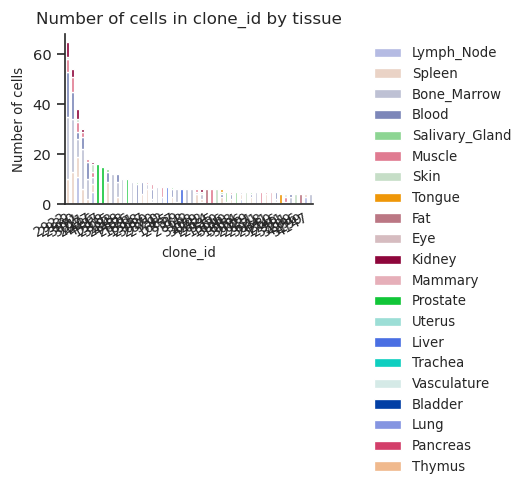

In [105]:
ax = ir.pl.group_abundance(adata, groupby='clone_id', target_col='tissue', max_cols=50)

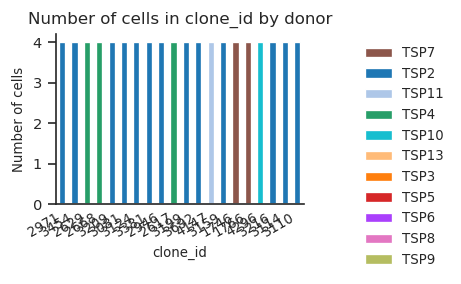

In [108]:
ax = ir.pl.group_abundance(adata[adata.obs.clone_id_size  <= 4], groupby='clone_id', target_col='donor', max_cols=20)


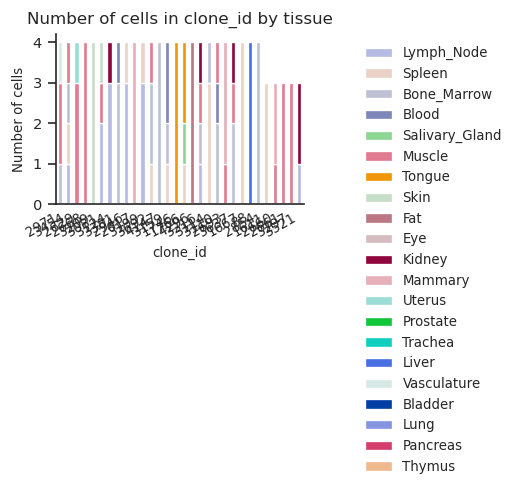

In [109]:
ax = ir.pl.group_abundance(adata[adata.obs.clone_id_size  <= 4], groupby='clone_id', target_col='tissue', max_cols=30)


In [42]:
selector = adata.obs.groupby('clone_id')['donor'].nunique() > 1

selector = selector[selector == True].index

In [48]:
multi_donor = adata[adata.obs.clone_id.isin(selector)]
multi_donor_TCR = multi_donor[multi_donor.obs.receptor_type == 'TCR']

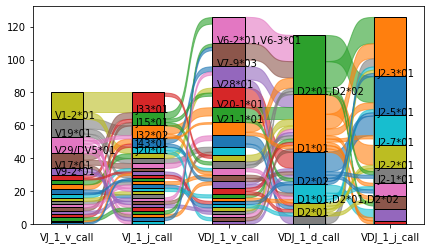

In [82]:
ax = ir.pl.vdj_usage(
    multi_donor_TCR,
    max_ribbons=None,
    max_segments=100, full_combination=False
)


In [111]:
multi_donor_TCR.obs.IR_VJ_1_v_call.value_counts()

TRAV1-2*01       16
TRAV19*01        11
TRAV29/DV5*01    10
TRAV17*01         9
TRAV9-2*01        4
TRAV8-1*01        3
TRAV24*01         3
TRAV13-1*02       3
TRAV12-2*01       3
TRAV21*01         2
TRAV25*01         2
TRAV26-1*01       2
TRAV27*01         2
TRAV36/DV7*01     2
TRAV5*01          2
TRAV7*01          2
TRAV1-1*01        2
TRAV13-1*01       1
TRAV12-2*02       1
Name: IR_VJ_1_v_call, dtype: int64

In [83]:
ax.figure.set_size_inches(20,20)

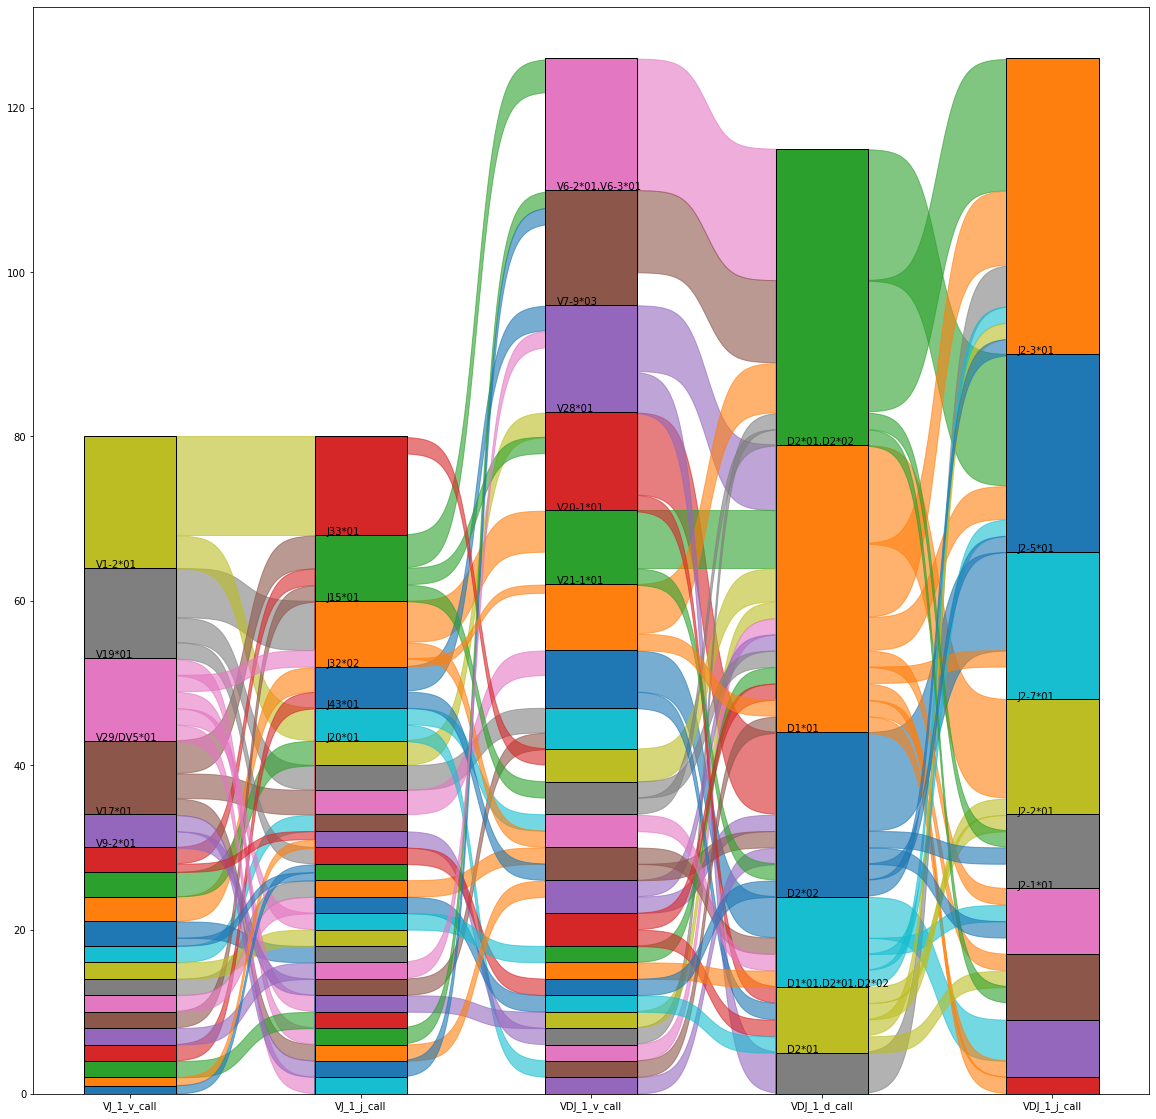

In [84]:
ax.figure

In [87]:
import pandas as pd
import numpy as np
import scanpy as sc
%matplotlib inline
from matplotlib import pyplot as plt
import Levenshtein
import matplotlib as mpl
import seaborn as sns
import autoreload
import scipy
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 10,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 100
   }

mpl.rcParams.update(params)

sns.set_style("ticks")
sns.set_context(context='paper')
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": False}
mpl.rc('savefig', dpi=300)
output_dir='../figures'
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [89]:
save_figure(ax.figure, 'TCR_V_gene_Usage')

In [92]:
selector = adata.obs.groupby('clone_id')['tissue'].nunique() 

selector = selector[selector == True].index

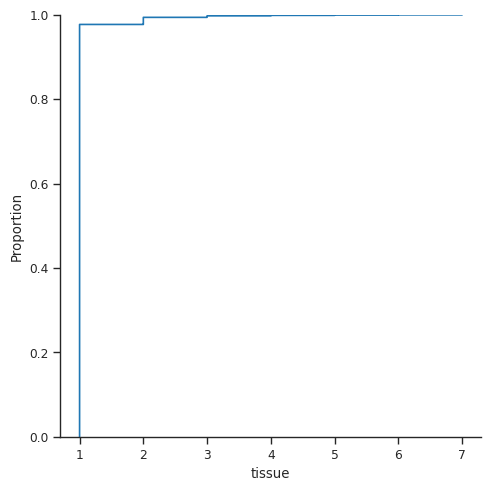

In [94]:
# All Cells
sns.displot(adata.obs.groupby('clone_id')['tissue'].nunique(), kind='ecdf')

In [95]:
adata_TCR = adata[adata.obs.receptor_type == 'TCR']

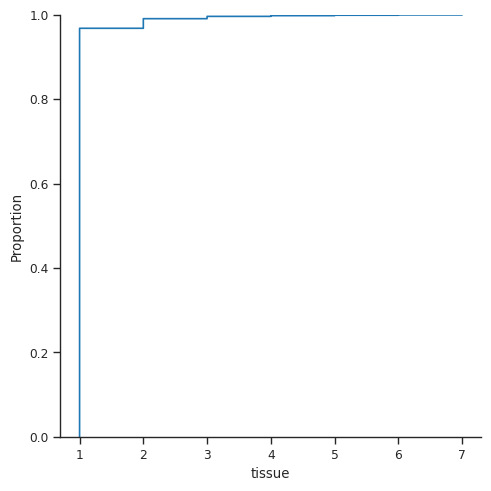

In [96]:
# All Cells
sns.displot(adata_TCR.obs.groupby('clone_id')['tissue'].nunique(), kind='ecdf')

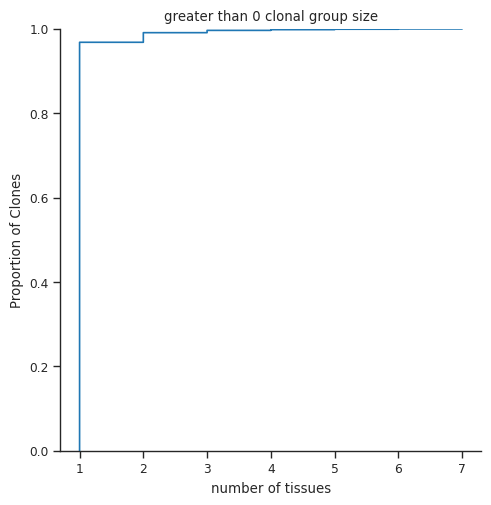

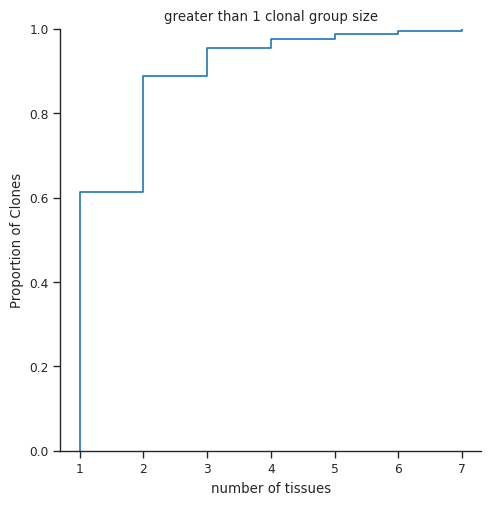

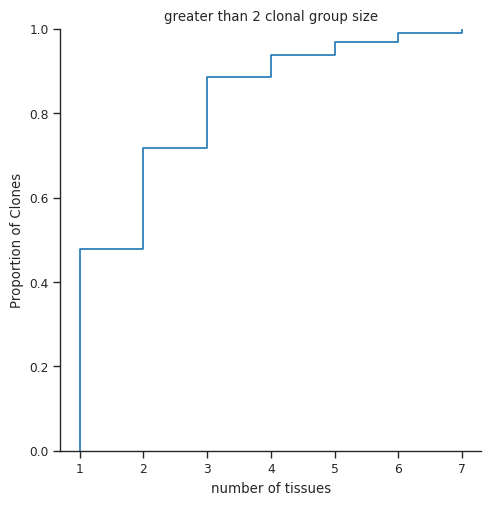

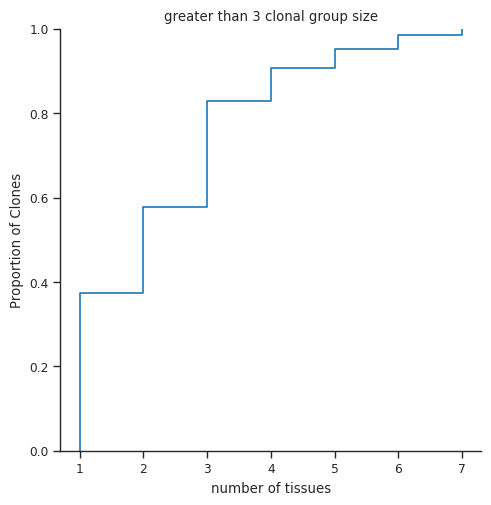

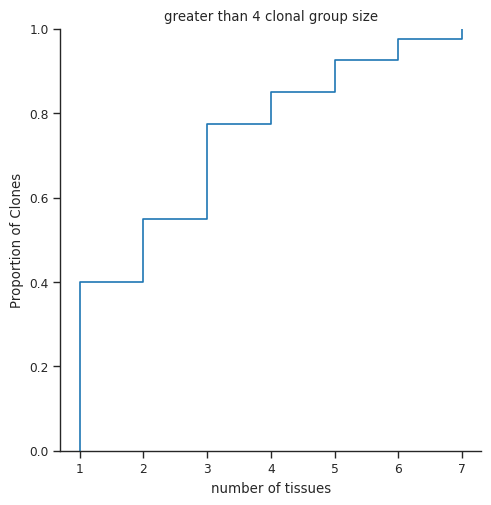

In [103]:
# All Cells
for i in range(5):
    _adata = adata_TCR[adata_TCR.obs.clone_id_size > i]
    sns.displot(_adata.obs.groupby('clone_id')['tissue'].nunique(), kind='ecdf')
    plt.title("greater than {} clonal group size".format(i))
    plt.xlabel('number of tissues')
    plt.ylabel('Proportion of Clones')
    